# Project Proposal - Analysis of factors impacting quality of vinho verde red wine

## Introduction

Wine quality depends on a multitude of factors, including quantifiable variables like its chemical properties. In this project, we aim to predict a numerical value indicating the quality of a specific wine using its chemical properties. In particular, we consider the red wine variant of the Portuguese vinho verde, using data provided by the Wine Quality Data Set (Cortez et al., 2009). The dataset consists of eleven predictor variables and one response variable, quality, which was based on the median of at least three experts' ratings between 0 and 10–referring to very bad and excellent, respectively. We aim to answer the central question: “Can the quality of red vinho verde wine be predicted using its chemical properties?”

## Preliminary exploratory data analysis

In [1]:
#installing and importing necessary libraries
install.packages("tidyverse")
install.packages("tidymodels")
install.packages("RColorBrewer")
install.packages("psych")
install.packages("ggcorrplot")
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(psych)
library(ggcorrplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows  

<font size="4">Reading, wrangling, and splitting the dataset</font>

In [2]:
# viewed the .csv file separately to determine the delimeter we need to use
# loading the dataset

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data <- read_delim(url,
                      delim = ";")

# renaming columns to remove spaces
colnames(wine_data) <- c("fixed_acidity",
                         "volatile_acidity", 
                         "citric_acid",
                         "residual_sugar", 
                         "chlorides",
                         "free_sulfur_dioxide", 
                         "total_sulfur_dioxide",
                         "density", 
                         "pH", 
                         "sulphates", 
                         "alcohol",
                         "quality",
                         "color")

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**quality** is the response variable and the remaining variables may be used as predictor variables.

In [3]:
# Checking for missing data/NA values
for (colnumber in 1:ncol(wine_data))
{na_vals <- sum(is.na(wine_data[,colnumber]))}
na_vals

[1] 0

There are no NA values to rectify.

Data is tidy as:
1. Each row is single observation
2. Each column is single variable
3. Each value is single cell

Splitting data into test and training sets, using 75% of data for training and 25% for testing, to aid the creation of an accurate model whose performance can be evaluated. A seed value is set to make the random distributions of data reproducible.

In [4]:
set.seed(1)
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

<font size="4">Summarizing and Visualizing the dataset</font>

Describing the summary statistics of each predictor variable.

In [5]:
# selecting all predictor variables
wine_train_without_qual <- wine_train |>
    select(-12)

# converting the summary() fuction using as.data.frame() and then renaming the column names
wine_summary_1 <- as.data.frame(apply(wine_train_without_qual, 2, summary))
colnames(wine_summary_1) <- c("Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides", "Free Sulfur Dioxide",
                             "Total Sulfur Dioxide", "Density", "pH", "Sulphates", "Alcohol")

# using describe() from the psych library to determine the skewness of the predictor variables and then renaming it
wine_skew <- as.data.frame(describe(wine_train_without_qual)) |>
    select(skew)
colnames(wine_skew) <- c("Skewness")
rownames(wine_skew) <- c("Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides", "Free Sulfur Dioxide",
                             "Total Sulfur Dioxide", "Density", "pH", "Sulphates", "Alcohol")

# transposing the data frame with the skewness values so we can bind the two summary statistics tables into one table
transp_wine_skew = t(wine_skew)
transp_wine_skew_df = as.data.frame(transp_wine_skew)

# binding the two summary data frames
final_summary_wine <- rbind(wine_summary_1, transp_wine_skew_df)
final_summary_wine

,Fixed Acidity,Volatile Acidity,Citric Acid,Residual Sugar,Chlorides,Free Sulfur Dioxide,Total Sulfur Dioxide,Density,pH,Sulphates,Alcohol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,4.6000000,0.1200000,0.0000000,0.900000,0.0120000,1.000000,6.000000,0.99007000,2.7400000,0.3300000,8.400000
1st Qu.,7.1000000,0.3912500,0.0900000,1.900000,0.0700000,7.000000,22.000000,0.99560500,3.2100000,0.5500000,9.500000
Median,7.9000000,0.5200000,0.2600000,2.200000,0.0790000,13.000000,38.000000,0.99676500,3.3100000,0.6200000,10.100000
Mean,8.3149416,0.5265735,0.2704591,2.549082,0.0873798,15.723289,46.380634,0.99675159,3.3100000,0.6564608,10.400250
3rd Qu.,9.2000000,0.6400000,0.4300000,2.600000,0.0900000,21.000000,62.000000,0.99783000,3.4000000,0.7300000,11.000000
Max.,15.9000000,1.5800000,1.0000000,15.500000,0.6110000,72.000000,289.000000,1.00369000,4.0100000,2.0000000,14.900000
Skewness,0.9939181,0.6594758,0.3172686,4.652658,5.8331448,1.310305,1.592568,0.07194448,0.1963142,2.4542637,0.864092


We speculate the presence of outliers because the range (max-min) is much larger than the interquartile range (IQR) for all predictor variables. Additionally, seen from the skewness measure, some predictors variables (such as free sulfur dioxide) are not distributed normally.

Visualizing this data for a subset of predictor variables can help analysis, done by first determining variables that have the most impact on wine quality.

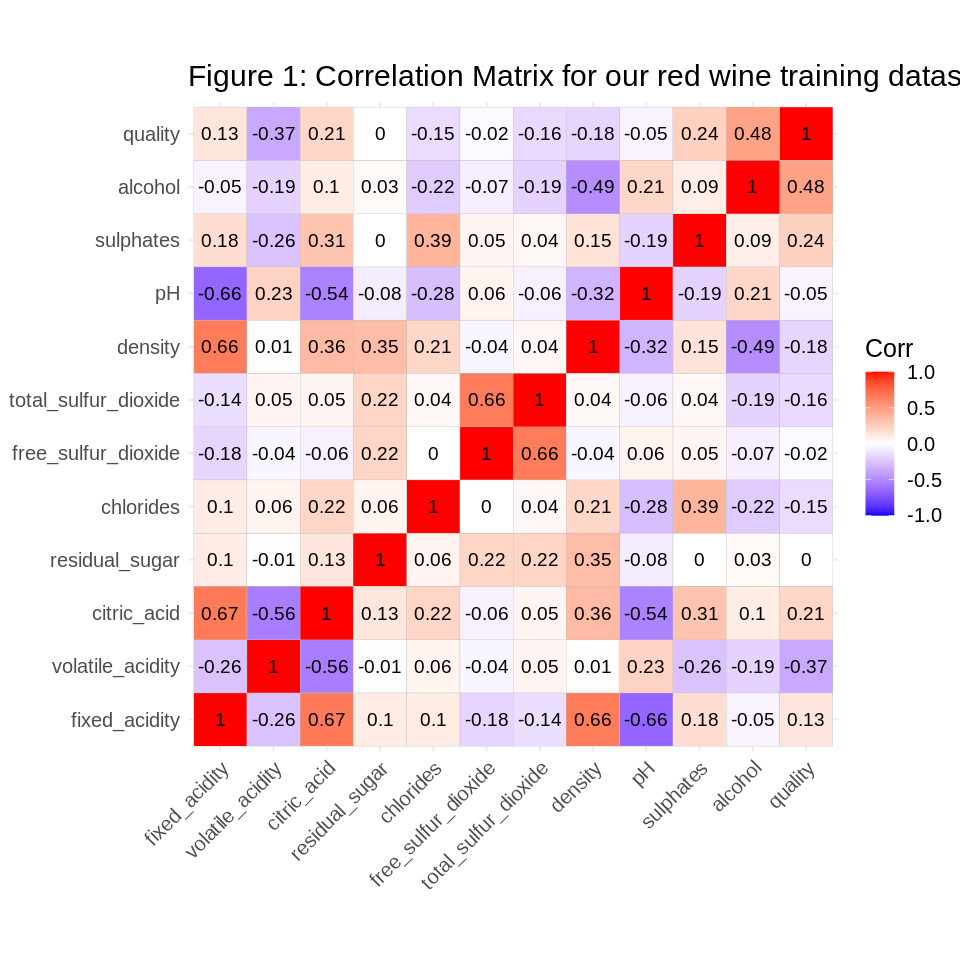

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)

# using cor() to determine the correlation matrix of our dataset
correlation_matrix = cor(wine_train)

# plotting the matrix using ggcorplot()
ggcorrplot(correlation_matrix, lab = TRUE) +
     ggtitle("Figure 1: Correlation Matrix for our red wine training dataset") +
    theme(text = element_text(size = 15))

Most predictor variables do not have high correlation with quality. The three highest correlated are alcohol, sulphates and citric acid.

<div align="center"> Table 1: The correlation of alcohol, sulphates and citric acid with quality  </div>

| Variable | Correlation                                 |
|--------|---------------------------------------------|
| Alcohol    | 0.48            |
| Sulphates      | 0.24           |
|   Citric Acid   | 0.21      |

Box plots allow us to determine if we have any outliers, and histograms allow us to check the type of distribution and data skew. These graphs are plot for the three variables with the highest correlation with quality.

The following investigation focuses on these three variables to use to predict the quality of red vinho verde wine.

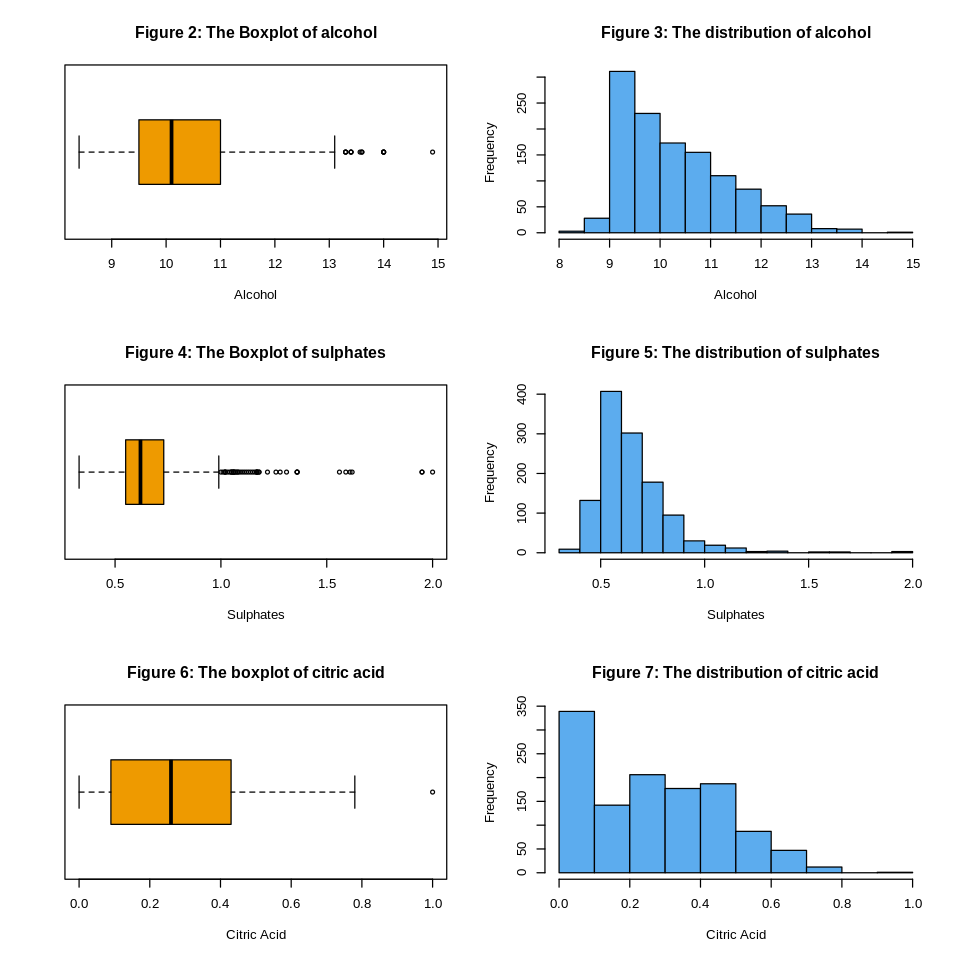

In [7]:
par(mfrow=c(3,2))

# alcohol plots
alcohol_p <- wine_train$alcohol
boxplot(alcohol_p, horizontal=TRUE,
       main = "Figure 2: The Boxplot of alcohol",
        xlab = "Alcohol",
       col = "orange2")
hist(alcohol_p,
    main = "Figure 3: The distribution of alcohol",
     xlab = "Alcohol",
    col = "steelblue2")

# sulphates plots
sulphates_p <- wine_train$sulphates
boxplot(sulphates_p, horizontal=TRUE,
       main = "Figure 4: The Boxplot of sulphates",
        xlab = "Sulphates",
       col = "orange2")
hist(sulphates_p,
    main = "Figure 5: The distribution of sulphates",
     xlab = "Sulphates",
    col = "steelblue2")

# citric_acid plots
citric_acid_p <- wine_train$citric_acid
boxplot(citric_acid_p, horizontal=TRUE,
    main = "Figure 6: The boxplot of citric acid",
        xlab = "Citric Acid",
    col = "orange2")
hist(citric_acid_p,
    main = "Figure 7: The distribution of citric acid",
     xlab = "Citric Acid",
    col = "steelblue2")

The predictor variables have many outliers, particularly alcohol and sulphates. As outliers negatively reduce the model accuracy and predictions, the data is further cleaned. A function removing outliers is utilized prior to analysis. 

The histograms also display the skewness, the distributions are skewed (to the right) and not distributed normally.

Now, we explore the target variable: quality

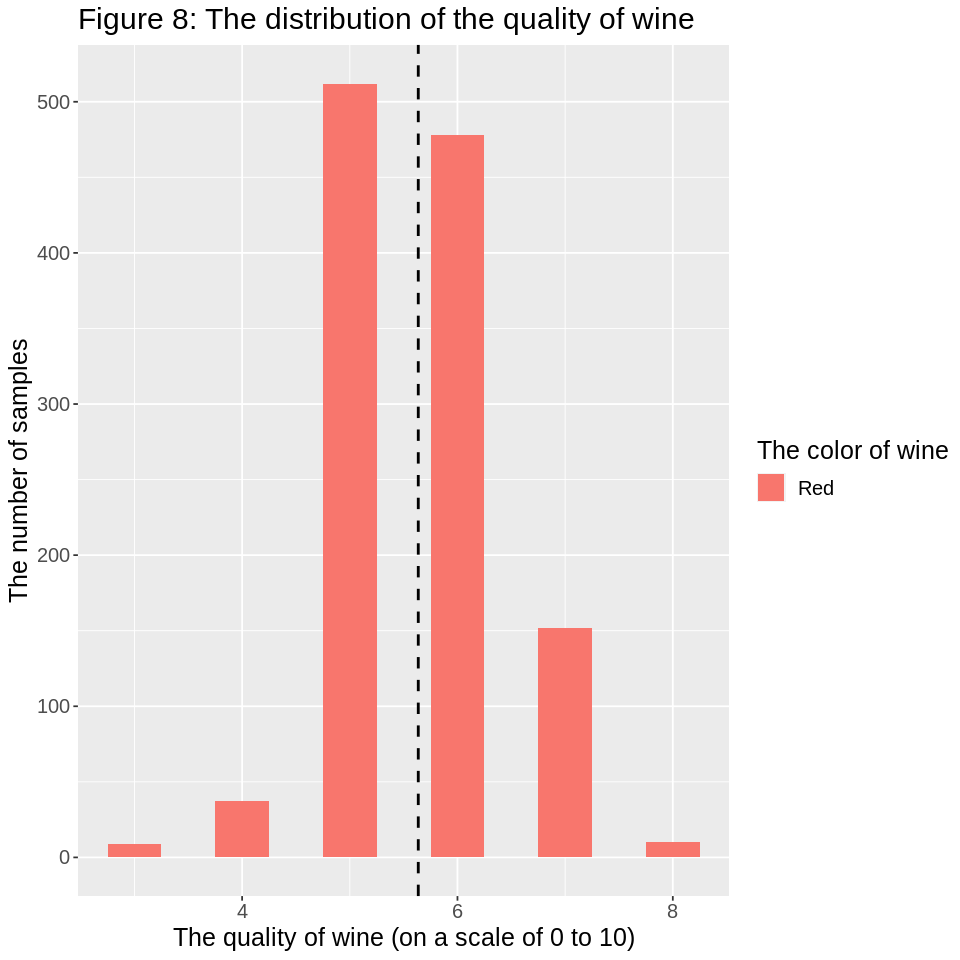

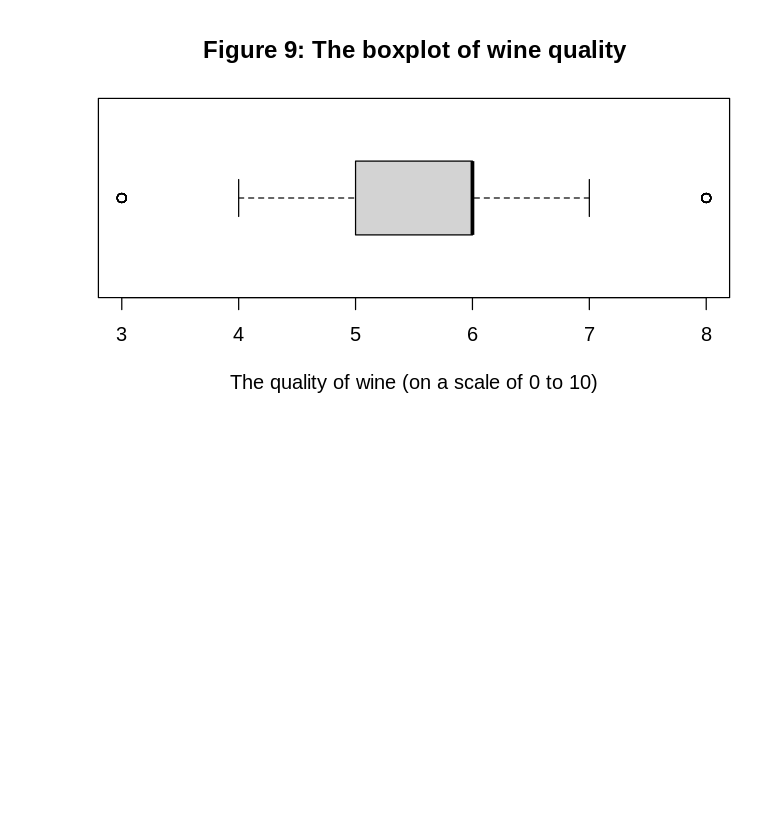

In [8]:
# finding the mean quality of overall red wine dataset
mean_quality <- wine_data |>
    summarize(mean = mean(quality)) |>
    pull()

par(mfrow=c(2,1))

# plotting these values. Using a histogram to represent the number of samples within the training data set
options(repr.plot.height = 8, repr.plot.width = 8)
hist_quality_plot <- wine_train |>
    ggplot(aes(x = quality,
              fill = "red")) +
    geom_histogram(binwidth = .5) +
    geom_vline(xintercept = mean_quality, linetype = "dashed", size = .8) +
    labs(x = "The quality of wine (on a scale of 0 to 10)",
         y = "The number of samples",
         title = "Figure 8: The distribution of the quality of wine",
        fill = "The color of wine") +
        theme(text = element_text(size = 15)) +
    scale_fill_discrete(labels = c("Red"))
hist_quality_plot

# plotting a boxplot to demonstrate the max, min, median and the outliers
options(repr.plot.height = 7, repr.plot.width = 6.5)
qual_box_p <- boxplot(wine_train$quality, horizontal=TRUE,
       main = "Figure 9: The boxplot of wine quality",
        xlab = "The quality of wine (on a scale of 0 to 10)")

Based on the vertical line on the histogram, the mean wine quality is approximately 5.6. The histogram demonstrates that no red wine samples have a quality less than 3 and greater than 8 (on scale of 0 to 10). The target variable, quality, is distributed normally as well.

## Method
We will use a multivariate regression model to predict wine quality. To train and test our model, we will use the data split created above. The predictor variables we will use are based on the correlation plot above: we use the three variables with the highest correlation with quality.

To create the regression model, we will create a recipe to standardize and center our data. Then, create a specification of our KNN model using the nearest_neighbors() function. Here, we will use cross-validation to evaluate model performance with different K values. We will then choose the value that minimizes the root mean square prediction error (RMSPE). This simultaneously helps identify a K value that avoids underfitting or overfitting. Then, we will use the workflow() function to combine our previous work and make a fit using our training data. We will then evaluate the model on the test set and compute a summary of the regression quality. 

The investigation will conclude by creating a confusion matrix that shows the number of true (and false) positives and true (and false) negatives for each discrete value of quality.

## Expected Outcomes
The model is expected to better predict wine quality when focusing on specific predictor variables, in particular alcohol, sulphates and citric acid. However, we hypothesize that the predictions will be somewhat inaccurate as there is a low correlation between quality and the considered predictor variables. 

## KNN Regression
### Tuning the K-NN classifer

In [9]:
# making the recipe and model for the KNN regression algorithm
wine_recipe <- recipe(quality ~ alcohol + sulphates + citric_acid, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

wine_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

gridvals <- tibble(neighbors = seq(from = 1, to = 50))

wine_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(wine_spec) |>
    tune_grid(resamples = wine_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

wine_min <- wine_results |>
  filter(mean == min(mean))

kmin <- wine_min |> 
    pull(neighbors)

k_min_mean <- wine_min |>
    select(mean) |>
    pull()

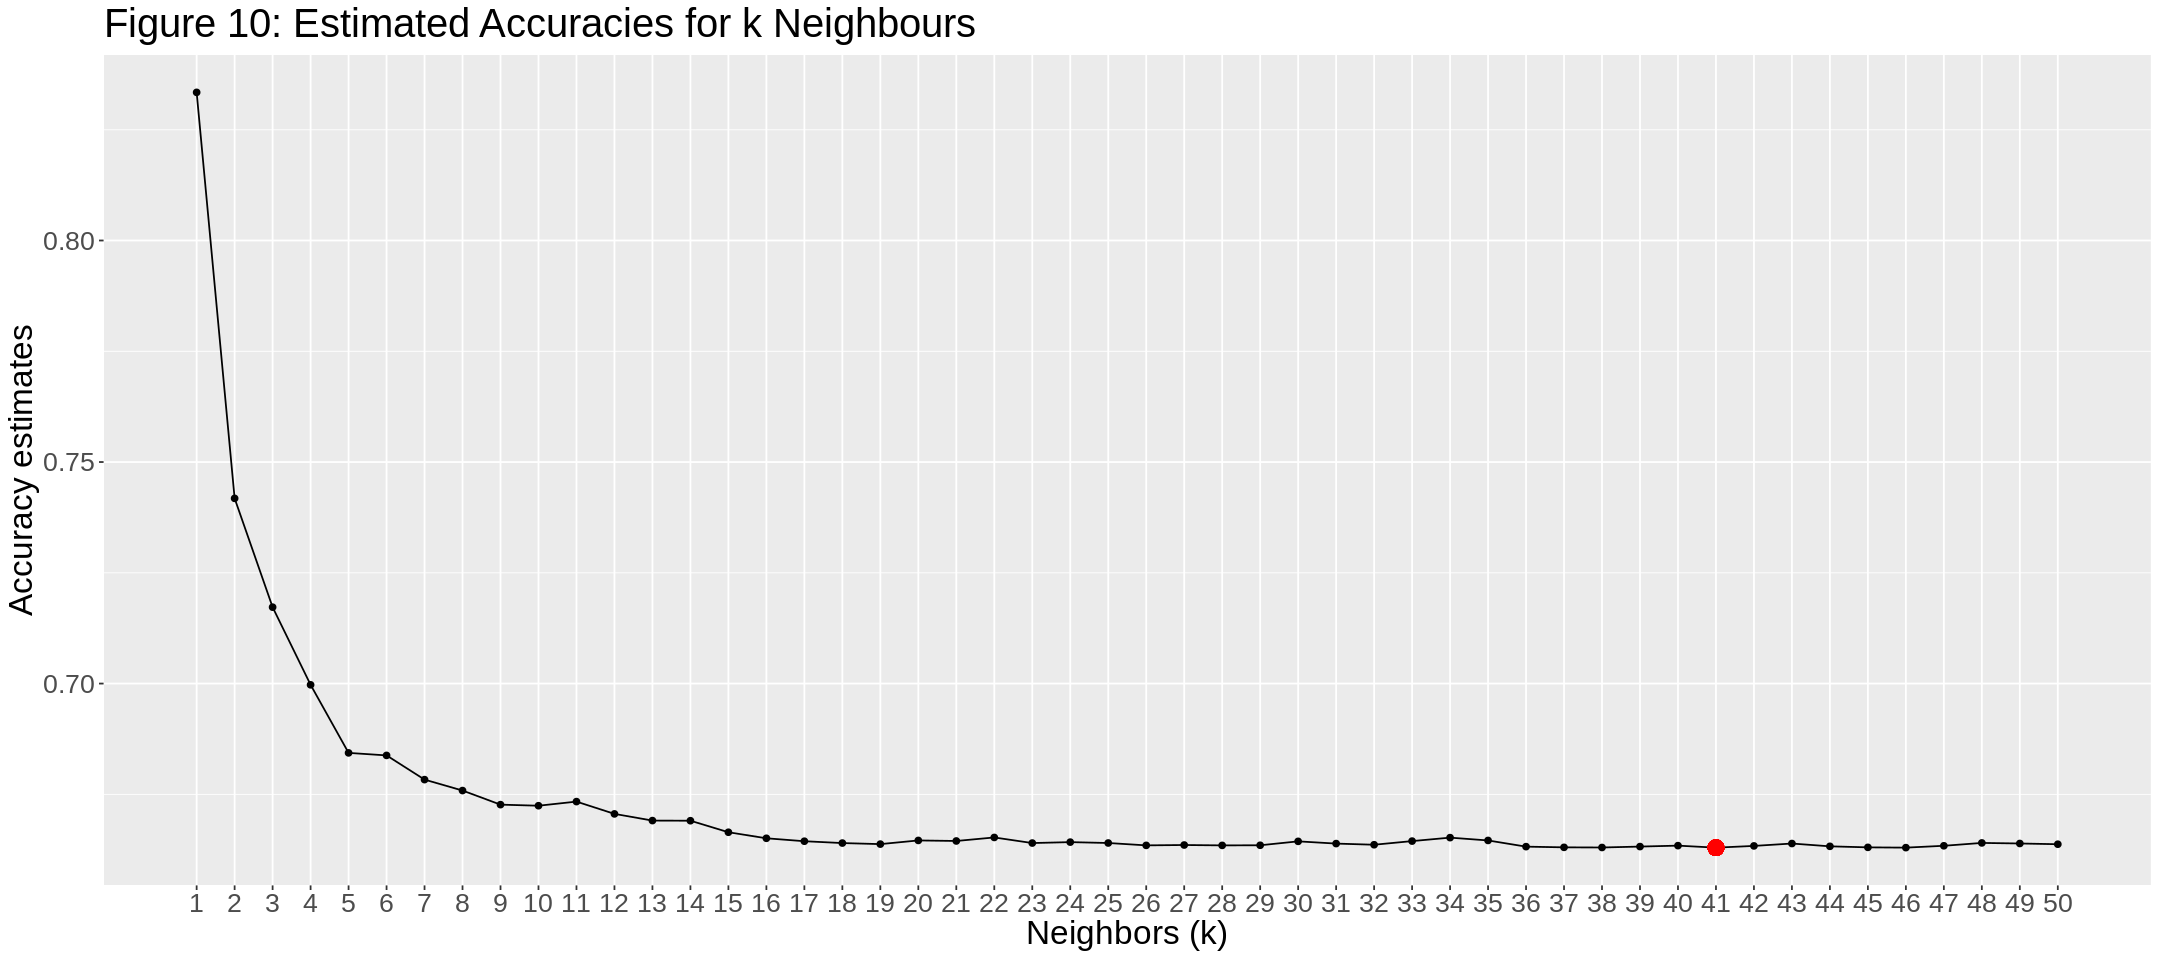

In [10]:
# plotting the accuracies determined for each k value to determine k value results in the most optimal RMSE

options(repr.plot.width = 18, repr.plot.height = 8)
min_k_vals_plot <- wine_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_point(aes(x=kmin, y= k_min_mean), size = 4, colour = "red") +
    labs(x = "Neighbors (k)",
         y = "Accuracy estimates") +
    ggtitle("Figure 10: Estimated Accuracies for k Neighbours") +
    scale_x_continuous(limits = c(1, 50), breaks = seq(1, 50), minor_breaks = seq(1, 50, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))
min_k_vals_plot

We can now perform our KNN regression analysis using the three predictors variables and a tuned value of K, which is 41.

In [11]:
#making a knn reg model which uses 41 neighbors
wine_spec_best <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

#creating a workflow using the appropriate functions and implementing the old recipe (which consits of the three variabeles
# and the best model which was made just above
wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(wine_spec_best) |>
    fit(data = wine_train)

#creating a data frame that consists of the true quality values from the original dataset and the predicted values found through the 
#workflow above
wine_preds <- wine_fit |>
    predict(wine_test) |>
    bind_cols(wine_test)

#determining the accuracy of our algorithm
wine_acc <- wine_preds |>
    metrics(truth = quality, estimate = .pred) |>
    select(.metric, .estimate) |>
    head(1) |>
    select(.estimate) |>
    pull()

#wine_acc # acc of our knn reg

### Confusion Matrix

To create a confusion matrix, we have to change quality to a categorical variable from a numerical variable. Treating this variable as categorical is identical to treating it as numerical due to the discrete nature of the numerical values (i.e. integers ranging from 3 to 9) within the quality column.

In [12]:
#using the as_factor function to change quality into a categorical factor

asfac_train <- wine_train |>
    mutate(quality = as_factor(quality))
asfac_test <- wine_test |>
    mutate(quality = as_factor(quality))

In [13]:
#creating a classification model using the min value of neighbors determined above
wine_spec_best <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(wine_spec_best) |>
    fit(data = asfac_train)
    
wine_preds <- wine_fit |>
    predict(asfac_test) |>
    bind_cols(asfac_test)

wine_acc <- wine_preds |>
    metrics(truth = quality, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

#creating the confusion matrix dataframe
wine_conf <- wine_preds |>
    conf_mat(truth = quality, estimate = .pred_class)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



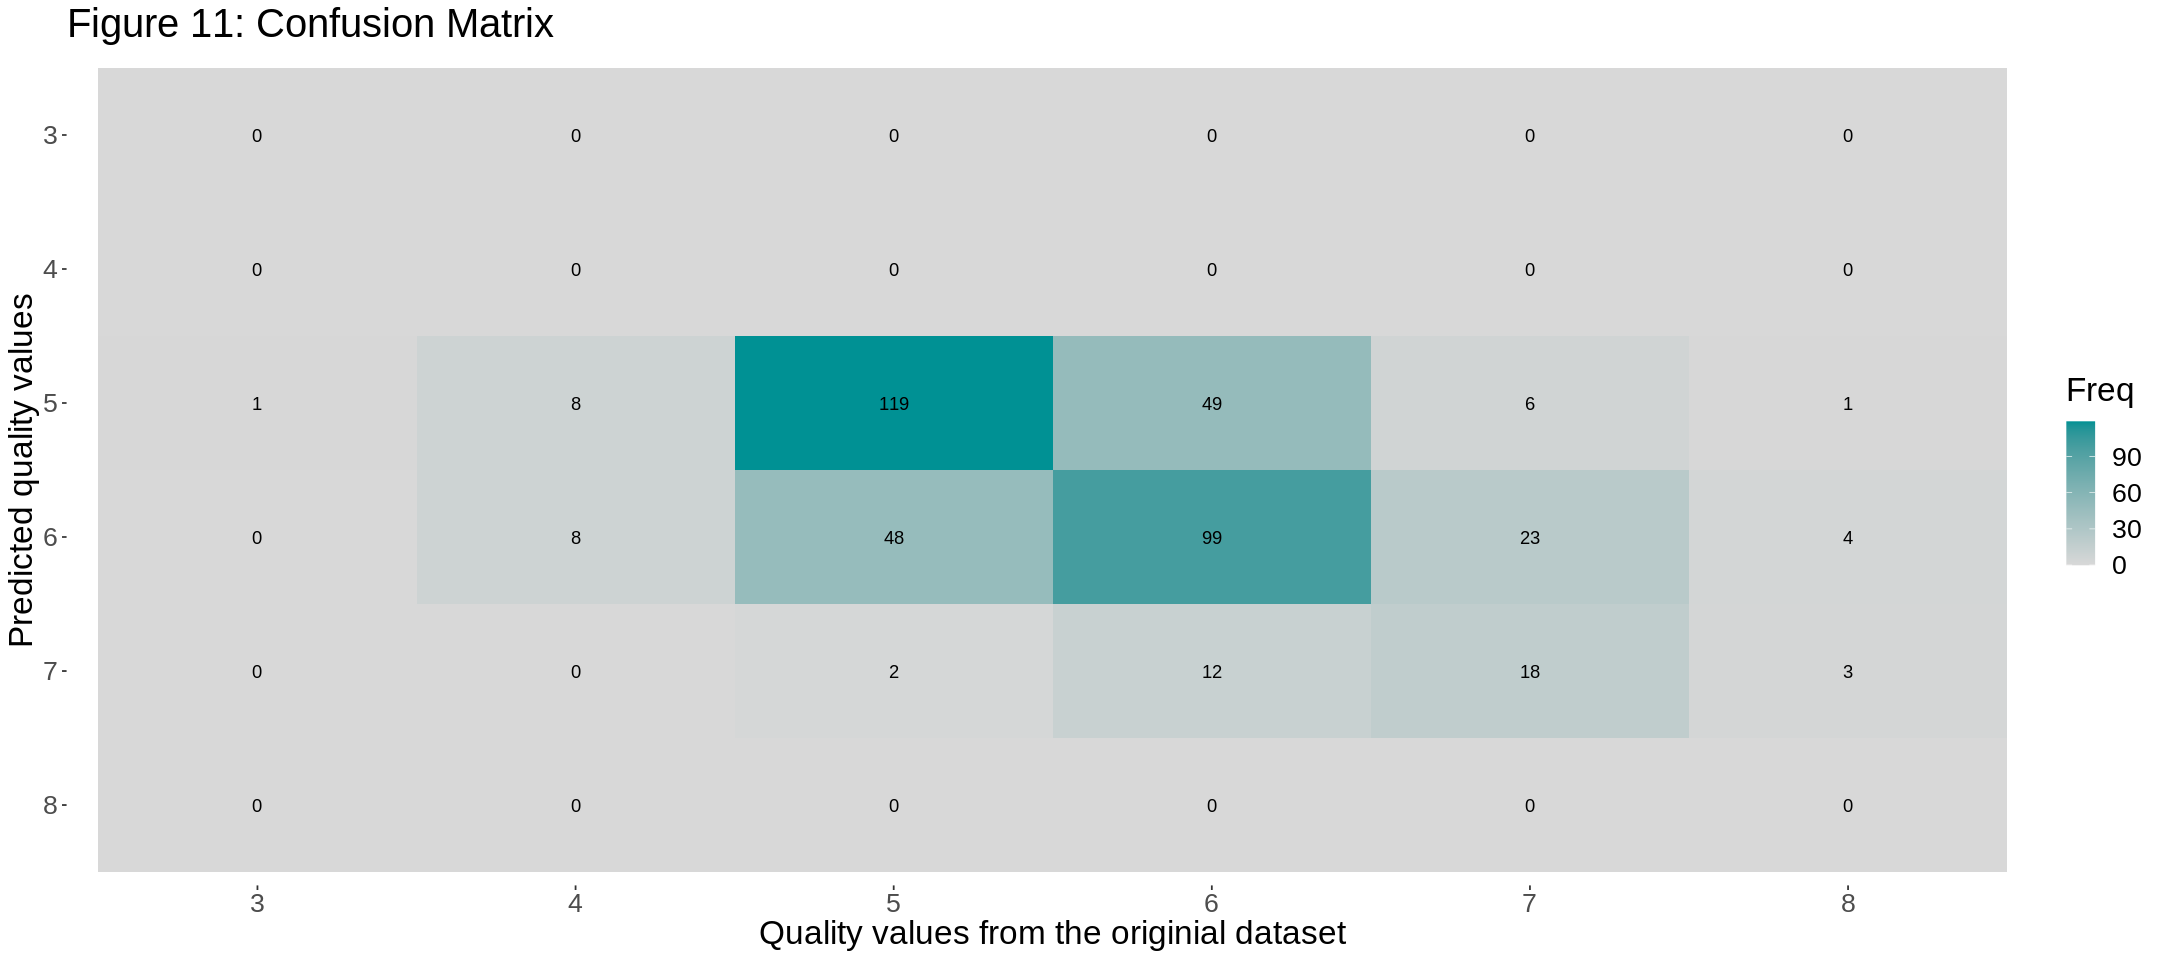

In [14]:
#creating the visualization of the df

conf_mat_viz <- wine_conf |>
    autoplot(type = "heatmap") +
    labs(x = "Quality values from the originial dataset", 
         y = "Predicted quality values", 
         title = "Figure 11: Confusion Matrix") +
    scale_fill_gradient(low = "#d8d8d8", high = "#009194") +
    theme(legend.position = "right", text = element_text(size = 20))
conf_mat_viz 

<div align="center"> Table 2 </div>

|.metric  | .estimate|
|:--------|---------:|
|accuracy | 0.677|


- We determined the accuracy of our predictions to be: 68%.
- We can visualize this metric from the confusion matrix above. For instance, we see that our algorithm incorrectly predicted a quality of 4 to be a quality of 5 eight times.

## Discussion

As seen from the analysis, using alcohol, sulphates and citric acid as our predictor variables enabled the creation of a KNN regression algorithm with a 67.7% accuracy (Table 2). Though these variables were chosen due to their highest correlation with quality, their correlation was still quite low (alcohol having the largest correlation (0.48 according to table 1)). We, therefore, expected the model's accuracy to not be as high, and the obtained accuracy of 67.7% aligned  with our expectation. Moreover, from the confusion matrix, we visualized the accuracy matrix, observing that the model performed relatively poor with quality values of 5 and 6. 48 "5" quality wines were predicted as quality "6", and 49 "6" quality wines were predicted as quality "5". <br>

Thereby, this leads to the primary limitation of the analysis: the imbalanced dataset. Our dataset consisted predominantly of wines which were rated either as 5 or 6, which hindered the model's ability to identify which factors influence the quality in what particular way. 

These findings limit the applicability of the model. While we expected that our findings could be used by producers of the vinho verde to improve wine quality, the uncertainty in the model's differentiation  of qualities 5 and 6 limit this application. We believe that further improvements such as balancing the data should be considered before applying this model in the real world. Nonetheless, the model helped understand that wine quality is not strongly predictable by any specific variables and presently continues to remain a subjective measure. 

Further questions:
1. Can our model be implemented on a dataset which consists of a different color wine? How would our current results compare?
2. How can we take into account the influence other variables (such as pH) may have on the quality of wine to further optimize our model?

## References

Calles, J. (2019). Predicting Style and Quality of Vinho Verde from
its Physical Properties. Semantic Scholar, 2019.

Kasimati, A., Espejo-Garcia, B., Vali, E., Malounas, I., & Fountas, S. (2021). Investigating a Selection of Methods for the Prediction of Total Soluble Solids Among Wine Grape Quality &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Characteristics Using Normalized Difference Vegetation Index Data From Proximal and Remote Sensing. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Frontiers in plant science,12,683078.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://doi.org/10.3389/fpls.2021.683078

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Decision Support Systems, Elsevier, 47(4):547-553, 2009.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://doi.org/10.1016/j.dss.2009.05.016

<b>Source of our datset:</b> https://archive.ics.uci.edu/ml/datasets/wine+quality